<a href="https://colab.research.google.com/github/kojikokojiko/portfoilio/blob/master/XGBOOST%26LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content/drive/My Drive/Colab Notebooks/Kaggle/Predict Future Sales

/content/drive/My Drive/Colab Notebooks/Kaggle/Predict Future Sales


In [0]:
import numpy as np
import pandas as pd
# pandasで表示が省略されるのを防ぐ
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',100)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from itertools import product
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error 

#LightGBMライブラリ
import lightgbm as lgb

In [0]:
items = pd.read_csv('./input/items.csv')
shops = pd.read_csv('./input/shops.csv')
cats = pd.read_csv('./input/item_categories.csv')
train = pd.read_csv('./input/sales_train.csv')
# IDをindexにおく
test  = pd.read_csv('./input/test.csv').set_index('ID')

In [49]:
test

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268
...,...,...
214195,45,18454
214196,45,16188
214197,45,15757


##データの可視化

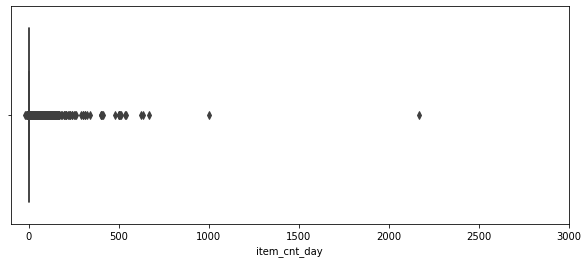

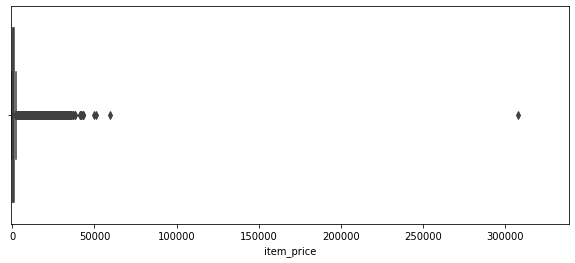

In [50]:
plt.figure(figsize=(10,4))
plt.xlim(-100,3000)
sns.boxplot(x=train['item_cnt_day'])

plt.figure(figsize=(10,4))
plt.xlim(-1000,train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)


##前処理

###外れ値、NANの処理

In [0]:
# おおきすぎる外れ値は外してやる
train=train[train.item_price<100000]
train=train[train.item_cnt_day<1500]

In [52]:
# グラフからitem_priceが負のあたい,（NaN）があるとわかる
# NANは代表値で埋めてやる

# まずnanを確認
train[train.item_price<0]


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [0]:
# 代表値の取り方
# shop_id、item_id、date_block_num、が同じものの中からその平均値をとってやる
#月によって、その店のその商品の価格は変動しているから実際は日ごとに変動しているらしい
mean=train[(train.item_id==2973)&(train.shop_id==32)&(train.date_block_num==4)&(train.date_block_num==4)&(train.item_price>0)].item_price.mean()
train.loc[train.item_price<0,'item_price']=mean
# train[条件式,条件によってしていされたDFのカラムを指定]=X
# で、その条件式を満たすDFの指定したカラムにXが入る



---



In [55]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [0]:
train.iloc[484683]

date              15.05.2013
date_block_num             4
shop_id                   32
item_id                 2973
item_price              1874
item_cnt_day               1
Name: 484683, dtype: object

無事穴埋め完了

### item_cnt_dayの負の値の処理

In [0]:
# item_cnt_dayの負の値も見ていく
train[train.item_cnt_day<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,05.01.2013,0,25,2552,899.0,-1.0
148,23.01.2013,0,25,2321,999.0,-1.0
175,07.01.2013,0,25,2199,1449.0,-1.0
807,02.01.2013,0,25,2330,599.0,-1.0
1041,13.01.2013,0,25,5034,1989.0,-1.0
...,...,...,...,...,...,...
2934243,26.10.2015,33,25,3917,449.0,-1.0
2934462,18.10.2015,33,25,4896,6398.0,-1.0
2935263,05.10.2015,33,25,10039,249.0,-1.0
2935643,16.10.2015,33,25,7893,2990.0,-1.0


In [0]:

train[train.item_cnt_day<0].item_cnt_day.value_counts()

-1.0     7252
-2.0       78
-3.0       14
-5.0        4
-4.0        3
-6.0        2
-9.0        1
-16.0       1
-22.0       1
Name: item_cnt_day, dtype: int64

In [0]:
# このマイナスの値は返品？という可能性を考えてとりあえずそのまま放置する
# 他の人のノートブックをみても放置している人が多かった

###shopで名前は違うが、同じ店を表すものがあるらしいのでマージする

In [0]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

###shop_nameの分解

shop_nameは

city名 お店の名前

みたいに表されているみたいなのでcity名だけのカラムを作ってやる



In [0]:
# Сергиев ПосадはСергиевПосадをcity名にするといいらしいのでその処理
shops.loc[shops.shop_name=='Сергиев Посад ТЦ "7Я"','shop_name']='СергиевПосад ТЦ "7Я"'
shops['city']=shops['shop_name'].str.split(' ').map(lambda x:x[0])
# !ЯкутскとЯкутскはおなじものらしいのでマージしてやる
shops.loc[shops.city=='!Якутск','city']='Якутск'
# ラベルエンコーディングでcity_nameダミー化
shops['city_code']=LabelEncoder().fit_transform(shops['city'])
shops=shops[['shop_id','city_code']]

###category_nameの分解
category_nameは
大分類-小分類で分かれているそうなので
大分類と小分類のカラムをそれぞれ作ってやる。その後ラベルエンコーディングしてやる




In [0]:
cats['split']=cats['item_category_name'].str.split('-')
cats['type']=cats['split'].map(lambda x:x[0].strip())
cats['type_code']=LabelEncoder().fit_transform(cats['type'])
# subtypeが存在しないばあいはtypeを入れる
cats['subtype']=cats['split'].map(lambda x:x[1].strip() if len(x)>1 else x[0].strip())
cats['subtype_code']=LabelEncoder().fit_transform(cats['subtype'])

cats=cats[['item_category_id','type_code','subtype_code']]



In [0]:
cats

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13
5,5,1,14
6,6,1,16
7,7,1,17
8,8,2,26
9,9,3,33


###item_name自体はいらないので消去

In [0]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [0]:
items.drop(['item_name'],axis=1,inplace=True)

###shop_id,item_idのテストデータ、trainデータで重複するものがどれくらいあるかを見る

In [0]:
def train_test_only1(columns):
  print('test_only,test,train,train_only')
  print(len(list(set(test[columns]) - set(test[columns]).intersection(set(train[columns])))),len(list(set(test[columns]))),len(list(set(train[columns]))),len(list(set(train[columns]) - set(train[columns]).intersection(set(test[columns])))))

In [0]:
train_test_only1('item_id')

test_only,test,train,train_only
363 5100 21806 17069


In [0]:
train_test_only1('shop_id')

test_only,test,train,train_only
0 42 57 15


####item_idにはtestデータにしかないidが363個ある
####shop_idにはtestデータにしかないidはない




## matrixを作っていく

prosuctで配列の中にある者同士のすべての組み合わせを取る

In [0]:
matrix=[]
cols=['date_block_num','shop_id','item_id']
for i in range(34):
  sales=train[train.date_block_num==i]
  matrix.append(np.array(list(product([i],sales.shop_id.unique(),sales.item_id.unique())),dtype='int16'))

In [0]:
matrix

[array([[    0,    59, 22154],
        [    0,    59,  2552],
        [    0,    59,  2554],
        ...,
        [    0,    45,   628],
        [    0,    45,   631],
        [    0,    45,   621]], dtype=int16), array([[    1,    50,  3880],
        [    1,    50,  4128],
        [    1,    50,  4124],
        ...,
        [    1,    28, 12885],
        [    1,    28, 12791],
        [    1,    28, 13433]], dtype=int16), array([[    2,     5, 20175],
        [    2,     5, 20083],
        [    2,     5,    31],
        ...,
        [    2,     4, 12388],
        [    2,     4, 12340],
        [    2,     4, 10649]], dtype=int16), array([[    3,    25,  8092],
        [    3,    25,  7850],
        [    3,    25,  8051],
        ...,
        [    3,    41, 14063],
        [    3,    41, 20690],
        [    3,    41, 19235]], dtype=int16), array([[    4,    59, 22114],
        [    4,    59, 20239],
        [    4,    59, 20238],
        ...,
        [    4,     6,  1924],
        [  

In [0]:
# 配列をたてに結合してDF化
matrix=pd.DataFrame(np.vstack(matrix),columns=cols)

In [0]:
# date_block_num,shop_id,item_idの優先度で昇順に並び替え
matrix.sort_values(cols,inplace=True)

In [0]:
# revenue（歳入）のカラムを作る
train['revenue']=train['item_price']*train['item_cnt_day']

###trainデータにあるitem_cnt_monthのデータをmatrixに反映させていく

In [0]:
group=train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day':['sum']})
group.columns=['item_cnt_month']
group.reset_index(inplace=True)
group

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0
...,...,...,...,...
1609118,33,59,22087,6.0
1609119,33,59,22088,2.0
1609120,33,59,22091,1.0
1609121,33,59,22100,1.0


In [0]:
matrix=pd.merge(matrix,group,on=cols,how='left')
matrix['item_cnt_month']=(matrix['item_cnt_month']
                          .fillna(0)
                          .clip(0,20))

In [0]:
matrix


,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0
...,...,...,...,...
10913799,33,59,22162,0.0
10913800,33,59,22163,0.0
10913801,33,59,22164,0.0
10913802,33,59,22166,0.0


###testデータをmatrixに結合させる

In [0]:
test['date_block_num']=34
test

,shop_id,item_id,date_block_num
ID,,,
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34
...,...,...,...
214195,45,18454,34
214196,45,16188,34
214197,45,15757,34


In [0]:
matrix=pd.concat([matrix,test],ignore_index=True,sort=False,keys=cols)
matrix

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0
...,...,...,...,...
11127999,34,45,18454,NaN
11128000,34,45,16188,NaN
11128001,34,45,15757,NaN
11128002,34,45,19648,NaN


In [0]:
matrix.fillna(0,inplace=True)

###shop、items,catsのデータをmatrixに反映させる

In [0]:
matrix=pd.merge(matrix,shops,on=['shop_id'],how='left')
matrix=pd.merge(matrix,items,on=['item_id'],how='left')
matrix=pd.merge(matrix,cats,on=['item_category_id'],how='left')



In [0]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code
0,0,2,19,0.0,0,40,11,4
1,0,2,27,1.0,0,19,5,10
2,0,2,28,0.0,0,30,8,55
3,0,2,29,0.0,0,23,5,16
4,0,2,32,0.0,0,40,11,4
...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,20,55,13,2
11128000,34,45,16188,0.0,20,64,14,42
11128001,34,45,15757,0.0,20,55,13,2
11128002,34,45,19648,0.0,20,40,11,4


##lag特徴量を作っていく


In [0]:
# lag特徴量を作る関数の作成
def lag_feature(df,lags,col):
  tmp=df[['date_block_num','shop_id','item_id',col]]
  for i in lags:
    shifted=tmp.copy()
    shifted.columns=['date_block_num','shop_id','item_id',col+'_lag_'+str(i)]
    shifted['date_block_num']+=i
    df=pd.merge(df,shifted,on=['date_block_num','shop_id','item_id'],how='left')
  return df

In [0]:
# item_cnt_monthのラグを取る
matrix=lag_feature(matrix,[1,2,3,6,12],'item_cnt_month')


In [0]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,2,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,20,55,13,2,1.0,0.0,0.0,0.0,NaN
11128000,34,45,16188,0.0,20,64,14,42,0.0,0.0,NaN,NaN,NaN
11128001,34,45,15757,0.0,20,55,13,2,0.0,0.0,0.0,0.0,0.0
11128002,34,45,19648,0.0,20,40,11,4,0.0,0.0,0.0,0.0,NaN


###様々な特徴量を掛け合わせ、そのラグを取っていく

####様々な特徴量を書けあわせて、月ごとの一日どれだけの個数itemが売れたかの平均を取る

In [0]:
# 月ごとに一日何個売れたかの平均を取る
group=matrix.groupby(['date_block_num']).agg({'item_cnt_month':['mean']})
group.columns=['date_avg_item_cnt']
group.reset_index(inplace=True)
matrix=pd.merge(matrix,group,on=['date_block_num'],how='left')
matrix=lag_feature(matrix,[1,2],'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'],axis=1,inplace=True)

In [0]:
# date_block_num＊item_idごとの平均を取る
group=matrix.groupby(['date_block_num','item_id']).agg({'item_cnt_month':['mean']})
group.columns=['date_item_avg_item_cnt']
group.reset_index(inplace=True)
matrix=pd.merge(matrix,group,on=['date_block_num','item_id'],how='left')
matrix=lag_feature(matrix,[1,2,3,6,12],'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'],axis=1,inplace=True)

In [0]:
# date_block_num＊shop_idごとの平均を取る
group=matrix.groupby(['date_block_num','shop_id']).agg({'item_cnt_month':['mean']})
group.columns=['date_shop_avg_item_cnt']
group.reset_index(inplace=True)
matrix=pd.merge(matrix,group,on=['date_block_num','shop_id'],how='left')
matrix=lag_feature(matrix,[1,2,3,6,12],'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'],axis=1,inplace=True)

In [0]:
# date_block_num＊item_category_idごとの平均を取る
group=matrix.groupby(['date_block_num','item_category_id']).agg({'item_cnt_month':['mean']})
group.columns=['date_cat_avg_item_cnt']
group.reset_index(inplace=True)
matrix=pd.merge(matrix,group,on=['date_block_num','item_category_id'],how='left')
matrix=lag_feature(matrix,[1,2],'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'],axis=1,inplace=True)

In [0]:
# date_block_num＊shop_id*item_categoryごとの平均を取る
group=matrix.groupby(['date_block_num','shop_id','item_category_id']).agg({'item_cnt_month':['mean']})
group.columns=['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)
matrix=pd.merge(matrix,group,on=['date_block_num','shop_id','item_category_id'],how='left')
matrix=lag_feature(matrix,[1,2],'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'],axis=1,inplace=True)

In [0]:
# date_block_num＊shop_id*type_codeごとの平均を取る
group=matrix.groupby(['date_block_num','shop_id','type_code']).agg({'item_cnt_month':['mean']})
group.columns=['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)
matrix=pd.merge(matrix,group,on=['date_block_num','shop_id','type_code'],how='left')
matrix=lag_feature(matrix,[1,2],'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'],axis=1,inplace=True)

In [0]:
# date_block_num＊shop_id*subtype_codeごとの平均を取る
group=matrix.groupby(['date_block_num','shop_id','subtype_code']).agg({'item_cnt_month':['mean']})
group.columns=['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)
matrix=pd.merge(matrix,group,on=['date_block_num','shop_id','subtype_code'],how='left')
matrix=lag_feature(matrix,[1,2],'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'],axis=1,inplace=True)

In [0]:
# date_block_num＊city_codeごとの平均を取る
group=matrix.groupby(['date_block_num','city_code']).agg({'item_cnt_month':['mean']})
group.columns=['date_city_avg_item_cnt']
group.reset_index(inplace=True)
matrix=pd.merge(matrix,group,on=['date_block_num','city_code'],how='left')
matrix=lag_feature(matrix,[1,2],'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'],axis=1,inplace=True)

In [0]:
# date_block_num＊type_codeごとの平均を取る
group=matrix.groupby(['date_block_num','type_code']).agg({'item_cnt_month':['mean']})
group.columns=['date_type_avg_item_cnt']
group.reset_index(inplace=True)
matrix=pd.merge(matrix,group,on=['date_block_num','type_code'],how='left')
matrix=lag_feature(matrix,[1,2],'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'],axis=1,inplace=True)

In [0]:
# date_block_num＊subtype_codeごとの平均を取る
group=matrix.groupby(['date_block_num','subtype_code']).agg({'item_cnt_month':['mean']})
group.columns=['date_subtype_avg_item_cnt']
group.reset_index(inplace=True)
matrix=pd.merge(matrix,group,on=['date_block_num','subtype_code'],how='left')
matrix=lag_feature(matrix,[1,2],'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'],axis=1,inplace=True)

In [0]:
# date_block_num＊city_code*subtype_codeごとの平均を取る
group=matrix.groupby(['date_block_num','city_code','subtype_code']).agg({'item_cnt_month':['mean']})
group.columns=['date_city_subtype_avg_item_cnt']
group.reset_index(inplace=True)
matrix=pd.merge(matrix,group,on=['date_block_num','city_code','subtype_code'],how='left')
matrix=lag_feature(matrix,[1,2],'date_city_subtype_avg_item_cnt')
matrix.drop(['date_city_subtype_avg_item_cnt'],axis=1,inplace=True)

In [0]:
# date_block_num＊city_code*subtype_codeごとの平均を取る
group=matrix.groupby(['date_block_num','city_code','type_code']).agg({'item_cnt_month':['mean']})
group.columns=['date_city_type_avg_item_cnt']
group.reset_index(inplace=True)
matrix=pd.merge(matrix,group,on=['date_block_num','city_code','type_code'],how='left')
matrix=lag_feature(matrix,[1,2],'date_city_type_avg_item_cnt')
matrix.drop(['date_city_type_avg_item_cnt'],axis=1,inplace=True)

In [0]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_cat_avg_item_cnt_lag_2,date_shop_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_2,date_shop_type_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_2,date_shop_subtype_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_2,date_city_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_2,date_type_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_2,date_subtype_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_2,date_city_subtype_avg_item_cnt_lag_1,date_city_subtype_avg_item_cnt_lag_2,date_city_type_avg_item_cnt_lag_1,date_city_type_avg_item_cnt_lag_2
0,0,2,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,20,55,13,2,1.0,0.0,0.0,0.0,NaN,0.258565,0.263758,0.045455,0.023256,0.071429,0.590909,NaN,0.126732,0.12881,0.138998,0.137611,NaN,0.196845,0.177560,0.126866,0.074534,0.089269,0.053816,0.126866,0.074534,0.135322,0.139036,0.147004,0.139012,0.196845,0.177560,0.155970,0.123447,0.107787,0.086106
11128000,34,45,16188,0.0,20,64,14,42,0.0,0.0,NaN,NaN,NaN,0.258565,0.263758,0.022727,0.069767,NaN,NaN,NaN,0.126732,0.12881,NaN,NaN,NaN,0.155870,0.167819,0.094488,0.117117,0.106202,0.112750,0.094488,0.117117,0.135322,0.139036,0.237314,0.216703,0.155870,0.167819,0.153543,0.189189,0.118097,0.122234
11128001,34,45,15757,0.0,20,55,13,2,0.0,0.0,0.0,0.0,0.0,0.258565,0.263758,0.113636,0.069767,0.095238,0.250000,0.18,0.126732,0.12881,0.138998,0.137611,0.181272,0.196845,0.177560,0.126866,0.074534,0.089269,0.053816,0.126866,0.074534,0.135322,0.139036,0.147004,0.139012,0.196845,0.177560,0.155970,0.123447,0.107787,0.086106
11128002,34,45,19648,0.0,20,40,11,4,0.0,0.0,0.0,0.0,NaN,0.258565,0.263758,0.045455,0.069767,0.166667,0.090909,NaN,0.126732,0.12881,0.138998,0.137611,NaN,0.220812,0.200956,0.083756,0.074074,0.097021,0.072562,0.083756,0.074074,0.135322,0.139036,0.224269,0.196066,0.220812,0.200956,0.111675,0.098978,0.119557,0.094482


###item_priceのの反映




In [0]:
# item_idごとにitem_priceの平均を取る
group=train.groupby(['item_id']).agg({'item_price':['mean']})
group.columns=['item_avg_item_price']
group.reset_index(inplace=True)
matrix=pd.merge(matrix,group,on=['item_id'],how='left')


In [0]:
# date_block_num*item_idごとのitem_priceの平均をもとめる
group=train.groupby(['date_block_num','item_id']).agg({'item_price':['mean']})
group.columns=['date_item_avg_item_price']
group.reset_index(inplace=True)
matrix=pd.merge(matrix,group,on=['date_block_num','item_id'],how='left')


In [0]:
# trainデータ全体から、item_idごとにitem_priceの平均を取ったものと、月ごとitem_idごとにitem_priceの平均を取ったものとの誤差率をだす
matrix['dif_date_item_price']=  (matrix['date_item_avg_item_price'] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']



In [0]:
# ラグを取る
matrix=lag_feature(matrix,[1,2],'dif_date_item_price')

###revenueの反映

In [0]:
# date_block_num*shop_idごとのrevenueの平均をもとめる
group=train.groupby(['date_block_num','shop_id']).agg({'revenue':['mean']})
group.columns=['date_shop_avg_revenue']
group.reset_index(inplace=True)
matrix=pd.merge(matrix,group,on=['date_block_num','shop_id'],how='left')


In [0]:
# shop_idごとのrevenueの平均をもとめる
group=train.groupby(['shop_id']).agg({'revenue':['mean']})
group.columns=['shop_avg_revenue']
group.reset_index(inplace=True)
matrix=pd.merge(matrix,group,on=['shop_id'],how='left')



In [0]:
# trainデータ全体から、item_idごとにrevenueの平均を取ったものと、月ごとitem_idごとにrevenueの平均を取ったものとの誤差率をだす
matrix['dif_date_revenue']=  (matrix['date_shop_avg_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']

In [0]:
# ラグを取る
matrix=lag_feature(matrix,[1,2],'dif_date_item_price')

### 細かな処理


In [0]:
# 月を記述
matrix['month']=matrix['date_block_num']%12


In [0]:
# 月の日数を示すカラムを追加
days=pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days']=matrix['month'].map(days)

In [0]:
# 12か月まえまでのラグを取っているので、date_block_numの0~11までを消してやる
matrix=matrix[matrix['date_block_num']>11]


In [0]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_cat_avg_item_cnt_lag_2,date_shop_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_2,date_shop_type_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_2,date_shop_subtype_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_2,date_city_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_2,date_type_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_2,date_subtype_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_2,date_city_subtype_avg_item_cnt_lag_1,date_city_subtype_avg_item_cnt_lag_2,date_city_type_avg_item_cnt_lag_1,date_city_type_avg_item_cnt_lag_2,item_avg_item_price,date_item_avg_item_price,dif_date_item_price,dif_date_item_price_lag_1_x,dif_date_item_price_lag_2_x,date_shop_avg_revenue,shop_avg_revenue,dif_date_revenue,dif_date_item_price_lag_1_y,dif_date_item_price_lag_2_y,month,days
4488710,12,2,27,0.0,0,19,5,10,0.0,0.0,0.0,0.0,1.0,0.411299,0.303260,0.086957,0.044444,0.130435,0.065217,0.155556,0.148118,0.10063,0.089066,0.096014,0.141220,1.082474,0.765351,0.955326,0.571429,0.808824,0.499106,0.934844,0.521886,0.148118,0.100630,1.034303,0.716239,1.075009,0.704227,0.934844,0.521886,0.808824,0.499106,1461.228571,998.000000,-0.317013,-0.282795,-0.180142,1244.243373,1694.80354,-0.265848,-0.282795,-0.180142,0,31
4488711,12,2,30,0.0,0,40,11,4,0.0,0.0,0.0,0.0,NaN,0.411299,0.303260,1.021739,1.022222,0.521739,0.891304,NaN,0.148118,0.10063,0.089066,0.096014,NaN,0.291505,0.244913,0.046246,0.022940,0.051719,0.031741,0.046246,0.022940,0.148118,0.100630,0.269904,0.221425,0.291505,0.244913,0.046246,0.022940,0.051719,0.031741,323.679206,169.000000,-0.477878,-0.483264,-0.489564,1244.243373,1694.80354,-0.265848,-0.483264,-0.489564,0,31
4488712,12,2,31,0.0,0,37,11,1,0.0,0.0,0.0,0.0,NaN,0.411299,0.303260,0.543478,0.600000,0.543478,0.304348,NaN,0.148118,0.10063,0.089066,0.096014,NaN,0.232808,0.183129,0.059459,0.046823,0.051719,0.031741,0.064690,0.048462,0.148118,0.100630,0.269904,0.221425,0.233994,0.183432,0.064690,0.048462,0.051719,0.031741,578.630005,499.000000,-0.137618,-0.137618,-0.155976,1244.243373,1694.80354,-0.265848,-0.137618,-0.155976,0,31
4488713,12,2,32,1.0,0,40,11,4,0.0,0.0,0.0,0.0,0.0,0.411299,0.303260,1.934783,1.800000,1.260870,1.891304,5.377778,0.148118,0.10063,0.089066,0.096014,0.141220,0.291505,0.244913,0.046246,0.022940,0.051719,0.031741,0.046246,0.022940,0.148118,0.100630,0.269904,0.221425,0.291505,0.244913,0.046246,0.022940,0.051719,0.031741,249.629240,144.710526,-0.420298,-0.407143,-0.421877,1244.243373,1694.80354,-0.265848,-0.407143,-0.421877,0,31
4488714,12,2,33,1.0,0,37,11,1,1.0,2.0,0.0,0.0,1.0,0.411299,0.303260,0.913043,0.333333,0.717391,1.000000,1.355556,0.148118,0.10063,0.089066,0.096014,0.141220,0.232808,0.183129,0.059459,0.046823,0.051719,0.031741,0.064690,0.048462,0.148118,0.100630,0.269904,0.221425,0.233994,0.183432,0.064690,0.048462,0.051719,0.031741,252.831928,197.487805,-0.218897,-0.225177,-0.229264,1244.243373,1694.80354,-0.265848,-0.225177,-0.229264,0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,20,55,13,2,1.0,0.0,0.0,0.0,NaN,0.258565,0.263758,0.045455,0.023256,0.071429,0.590909,NaN,0.126732,0.12881,0.138998,0.137611,NaN,0.196845,0.177560,0.126866,0.074534,0.089269,0.053816,0.126866,0.074534,0.135322,0.139036,0.147004,0.139012,0.196845,0.17756

In [0]:
matrix.isnull().any()

date_block_num                          False
shop_id                                 False
item_id                                 False
item_cnt_month                          False
city_code                               False
item_category_id                        False
type_code                               False
subtype_code                            False
item_cnt_month_lag_1                     True
item_cnt_month_lag_2                     True
item_cnt_month_lag_3                     True
item_cnt_month_lag_6                     True
item_cnt_month_lag_12                    True
date_avg_item_cnt_lag_1                  True
date_avg_item_cnt_lag_2                  True
date_item_avg_item_cnt_lag_1             True
date_item_avg_item_cnt_lag_2             True
date_item_avg_item_cnt_lag_3             True
date_item_avg_item_cnt_lag_6             True
date_item_avg_item_cnt_lag_12            True
date_shop_avg_item_cnt_lag_1             True
date_shop_avg_item_cnt_lag_2      

In [0]:
matrix.fillna(0,inplace=True)

In [0]:
matrix.isnull().any()

In [0]:
matrix.info()

In [0]:
# pklデータに落とし込む
matrix.to_pickle('data.pkl')

In [0]:
# 再読み込み
data = pd.read_pickle('data.pkl')

In [5]:
data.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_item_avg_item_cnt_lag_12',
       'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_2',
       'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6',
       'date_shop_avg_item_cnt_lag_12', 'date_cat_avg_item_cnt_lag_1',
       'date_cat_avg_item_cnt_lag_2', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_cat_avg_item_cnt_lag_2', 'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_2',
       'date_shop_subtype_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cn

In [0]:
data=data[[
           'date_block_num', 
           'shop_id', 
           'item_id', 
           'item_cnt_month', 
           'city_code',
           'item_category_id', 
           'type_code',  
           'subtype_code',  
           'item_cnt_month_lag_1',
           'item_cnt_month_lag_2',  
           'item_cnt_month_lag_3', 
           'item_cnt_month_lag_6',
           'item_cnt_month_lag_12', 
           'date_avg_item_cnt_lag_1',
           'date_avg_item_cnt_lag_2', 
           'date_item_avg_item_cnt_lag_1',
           'date_item_avg_item_cnt_lag_2',  
           'date_item_avg_item_cnt_lag_3',
           'date_item_avg_item_cnt_lag_6', 
           'date_item_avg_item_cnt_lag_12',
           'date_shop_avg_item_cnt_lag_1', 
           'date_shop_avg_item_cnt_lag_2',
           'date_shop_avg_item_cnt_lag_3', 
           'date_shop_avg_item_cnt_lag_6',
           'date_shop_avg_item_cnt_lag_12', 
           'date_cat_avg_item_cnt_lag_1',
           'date_cat_avg_item_cnt_lag_2', 
           'date_shop_cat_avg_item_cnt_lag_1',
           'date_shop_cat_avg_item_cnt_lag_2', 
           'date_shop_type_avg_item_cnt_lag_1',
           'date_shop_type_avg_item_cnt_lag_2',
           'date_shop_subtype_avg_item_cnt_lag_1',
           'date_shop_subtype_avg_item_cnt_lag_2', 
           'date_city_avg_item_cnt_lag_1',
           'date_city_avg_item_cnt_lag_2', 
           'date_type_avg_item_cnt_lag_1',
           'date_type_avg_item_cnt_lag_2', 
           'date_subtype_avg_item_cnt_lag_1',
           'date_subtype_avg_item_cnt_lag_2',
           'date_city_subtype_avg_item_cnt_lag_1',
           'date_city_subtype_avg_item_cnt_lag_2',
           'date_city_type_avg_item_cnt_lag_1',
           'date_city_type_avg_item_cnt_lag_2',   
           'item_avg_item_price',
          #  'date_item_avg_item_price', 
          #  'dif_date_item_price',
           'dif_date_item_price_lag_1_x', 
           'dif_date_item_price_lag_2_x',
          #  'date_shop_avg_revenue', 
           'shop_avg_revenue',
          #  'dif_date_revenue',
          #  'dif_date_item_price_lag_1_y', 
          #  'dif_date_item_price_lag_2_y', 
           'month',
           'days'
           









]]

In [7]:
data

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_cat_avg_item_cnt_lag_2,date_shop_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_2,date_shop_type_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_2,date_shop_subtype_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_2,date_city_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_2,date_type_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_2,date_subtype_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_2,date_city_subtype_avg_item_cnt_lag_1,date_city_subtype_avg_item_cnt_lag_2,date_city_type_avg_item_cnt_lag_1,date_city_type_avg_item_cnt_lag_2,item_avg_item_price,dif_date_item_price_lag_1_x,dif_date_item_price_lag_2_x,shop_avg_revenue,month,days
4488710,12,2,27,0.0,0,19,5,10,0.0,0.0,0.0,0.0,1.0,0.411299,0.303260,0.086957,0.044444,0.130435,0.065217,0.155556,0.148118,0.10063,0.089066,0.096014,0.141220,1.082474,0.765351,0.955326,0.571429,0.808824,0.499106,0.934844,0.521886,0.148118,0.100630,1.034303,0.716239,1.075009,0.704227,0.934844,0.521886,0.808824,0.499106,1461.228571,-0.282795,-0.180142,1694.80354,0,31
4488711,12,2,30,0.0,0,40,11,4,0.0,0.0,0.0,0.0,0.0,0.411299,0.303260,1.021739,1.022222,0.521739,0.891304,0.000000,0.148118,0.10063,0.089066,0.096014,0.000000,0.291505,0.244913,0.046246,0.022940,0.051719,0.031741,0.046246,0.022940,0.148118,0.100630,0.269904,0.221425,0.291505,0.244913,0.046246,0.022940,0.051719,0.031741,323.679206,-0.483264,-0.489564,1694.80354,0,31
4488712,12,2,31,0.0,0,37,11,1,0.0,0.0,0.0,0.0,0.0,0.411299,0.303260,0.543478,0.600000,0.543478,0.304348,0.000000,0.148118,0.10063,0.089066,0.096014,0.000000,0.232808,0.183129,0.059459,0.046823,0.051719,0.031741,0.064690,0.048462,0.148118,0.100630,0.269904,0.221425,0.233994,0.183432,0.064690,0.048462,0.051719,0.031741,578.630005,-0.137618,-0.155976,1694.80354,0,31
4488713,12,2,32,1.0,0,40,11,4,0.0,0.0,0.0,0.0,0.0,0.411299,0.303260,1.934783,1.800000,1.260870,1.891304,5.377778,0.148118,0.10063,0.089066,0.096014,0.141220,0.291505,0.244913,0.046246,0.022940,0.051719,0.031741,0.046246,0.022940,0.148118,0.100630,0.269904,0.221425,0.291505,0.244913,0.046246,0.022940,0.051719,0.031741,249.629240,-0.407143,-0.421877,1694.80354,0,31
4488714,12,2,33,1.0,0,37,11,1,1.0,2.0,0.0,0.0,1.0,0.411299,0.303260,0.913043,0.333333,0.717391,1.000000,1.355556,0.148118,0.10063,0.089066,0.096014,0.141220,0.232808,0.183129,0.059459,0.046823,0.051719,0.031741,0.064690,0.048462,0.148118,0.100630,0.269904,0.221425,0.233994,0.183432,0.064690,0.048462,0.051719,0.031741,252.831928,-0.225177,-0.229264,1694.80354,0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,20,55,13,2,1.0,0.0,0.0,0.0,0.0,0.258565,0.263758,0.045455,0.023256,0.071429,0.590909,0.000000,0.126732,0.12881,0.138998,0.137611,0.000000,0.196845,0.177560,0.126866,0.074534,0.089269,0.053816,0.126866,0.074534,0.135322,0.139036,0.147004,0.139012,0.196845,0.177560,0.155970,0.123447,0.107787,0.086106,188.681084,-0.475305,-0.475305,1140.25236,10,30
11128000,34,45,16188,0.0,20,64,14,42,0.0,0.0,0.0,0.0,0.0,0.258565,0.263758,0.022727,0.069767,0.000000,0.000000,0.000000,0.126732,0.12881,0.000000,0.000000,0.000000,0.155870,0.167819,0.094488,0.117117,0.106202,0.112750,0.094488,0.117117,0.135322,0.139036,0.237314,0.216703,0.155870,0.167819,0.153543,0.189189,0.118097,0.122234,1256.975000,0.081167,-0.027056,1140.2

###訓練、検証、テストデータ分け

In [0]:
X_train=data[data.date_block_num<33].drop(['item_cnt_month'],axis=1)
y_train=data[data.date_block_num<33]['item_cnt_month']
X_valid=data[data.date_block_num==33].drop(['item_cnt_month'],axis=1)
y_valid=data[data.date_block_num==33]['item_cnt_month']
X_test=data[data.date_block_num==34].drop(['item_cnt_month'],axis=1)



In [0]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid)

In [10]:
# パラメータサーチ
RMSE_list = []
count = []
for i in range(6, 13):
    params = {'boosting_type': 'gbdt',
          'objective': 'regression',
          'metric': 'rmse',
          'max_depth' : i}
    
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10000,
                valid_sets=lgb_eval,
                early_stopping_rounds=100,
                verbose_eval=50)
    
    predicted = gbm.predict(X_valid)
    pred_df = pd.concat([y_valid.reset_index(drop=True), pd.Series(predicted)], axis=1)
    pred_df.columns = ['true', 'pred']
    RMSE = np.sqrt(mean_squared_error(pred_df['true'], pred_df['pred']))
    RMSE_list.append(RMSE)
    count.append(i)

Training until validation scores don't improve for 100 rounds.


KeyboardInterrupt: ignored

In [11]:
params = {'boosting_type': 'gbdt',
         'objective': 'regression',
          'metric': 'rmse',
          'max_depth' : 8}
    

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10000,
                valid_sets=lgb_eval,
                early_stopping_rounds=100,
                verbose_eval=50)

Training until validation scores don't improve for 100 rounds.


KeyboardInterrupt: ignored

In [0]:
# model=xgb.XGBRegressor(
#     min_child_weight=300, 
#     colsample_bytree=0.8, 
#     subsample=0.8, 
#     eta=0.3,    
#     seed=42,
#     # ここに最適ハイパーパラメータを記入
#     max_depth=8,
#     n_estimators=1000
# )

In [0]:
# model.fit(
#     X_train,
#     y_train,
#     eval_metric='rmse',
#     eval_set=[(X_train,y_train),(X_valid,y_valid)],
#     early_stopping_rounds=10
# )

In [0]:
y_pred=model.predict(X_test).clip(0,20)
submission=pd.DataFrame([
    'ID':test.index,
    'item_cnt_month':y_pred
                         

])

###RNNモデルをつくっていく


In [12]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [13]:
import tensorflow as tf
import keras as keras
from keras.models import Sequential
from keras.layers import  LSTM,Dense,Dropout,RNN
from sklearn.metrics import mean_squared_error




Using TensorFlow backend.


In [14]:
model=Sequential()

model = Sequential()
model.add(LSTM(units=64, input_shape=(1, 48),dropout=0.1,recurrent_dropout=0.1))
model.add(Dense(1))

model.compile(loss='mse',
              optimizer='adam',
              metrics=['mean_squared_error'])
model.summary()







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                28928     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 28,993
Trainable params: 28,993
Non-trainable params: 0
_________________________________________________________________


In [0]:
X_train = np.reshape(X_train.values, (X_train.shape[0], 1, X_train.shape[1]))


X_test = np.reshape(X_test.values, (X_test.shape[0], 1, X_test.shape[1]))

X_valid = np.reshape(X_valid.values, (X_valid.shape[0], 1, X_valid.shape[1]))

In [0]:
eval_set=(X_valid,y_valid)

In [0]:
es_cb=keras.callbacks.EarlyStopping( patience=2, verbose=0)

In [21]:
history=model.fit(X_train,y_train,batch_size=2048,epochs=200,validation_data=eval_set,callbacks=[es_cb])

Train on 6186922 samples, validate on 238172 samples
Epoch 1/200
6186922/6186922 [==============================] - 24s 4us/step - loss: 0.9921 - mean_squared_error: 0.9921 - val_loss: 1.0231 - val_mean_squared_error: 1.0231
Epoch 2/200
6186922/6186922 [==============================] - 24s 4us/step - loss: 0.9970 - mean_squared_error: 0.9970 - val_loss: 1.0191 - val_mean_squared_error: 1.0191
Epoch 3/200
6186922/6186922 [==============================] - 24s 4us/step - loss: 1.0013 - mean_squared_error: 1.0013 - val_loss: 1.0071 - val_mean_squared_error: 1.0071
Epoch 4/200
6186922/6186922 [==============================] - 24s 4us/step - loss: 0.9809 - mean_squared_error: 0.9809 - val_loss: 1.0239 - val_mean_squared_error: 1.0239
Epoch 5/200
6186922/6186922 [==============================] - 24s 4us/step - loss: 0.9759 - mean_squared_error: 0.9759 - val_loss: 1.0021 - val_mean_squared_error: 1.0021
Epoch 6/200
6186922/6186922 [==============================] - 24s 4us/step - loss: 0.9

In [0]:
model.save('model.h5', include_optimizer=False)

In [0]:
# y_predを0から20の範囲に収めて、四捨五入
y_pred=model.predict(X_test).clip(0,20).round()

In [27]:
y_pred.shape

(214200, 1)

In [0]:
y_pred=y_pred.reshape(y_pred.shape[0])

In [29]:
y_pred

array([0., 0., 1., ..., 0., 0., 0.], dtype=float32)

In [0]:
submissionLSTM = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_pred
})

In [31]:
submissionLSTM[submissionLSTM.item_cnt_month>=1]

,ID,item_cnt_month
2,2,1.0
6,6,1.0
8,8,1.0
10,10,3.0
14,14,3.0
...,...,...
210836,210836,3.0
210970,210970,2.0
211581,211581,1.0
212340,212340,2.0


In [32]:
submissionLSTM

,ID,item_cnt_month
0,0,0.0
1,1,0.0
2,2,1.0
3,3,0.0
4,4,0.0
...,...,...
214195,214195,0.0
214196,214196,0.0
214197,214197,0.0
214198,214198,0.0


In [0]:
submissionLSTM

In [0]:
submissionLSTM.to_csv('LSTM.csv',index=False)